In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from astropy.table import Table
from tqdm.notebook import tqdm

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc30-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/InstallArea/x86_64-fc30-gcc92-dbg/python/')

In [3]:
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/InstallArea/x86_64-fc30-gcc92-dbg/auxdir/'

In [4]:
from nnpz import ReferenceSample
from nnpz.photometry import *

In [5]:
reference_sample_path = '/home/aalvarez/Work/Data/PHZ_Prod_conf/data/'
filters_path = '/home/aalvarez/Phosphoros/AuxiliaryData/Filters/SC456/'

In [6]:
ref_sample = ReferenceSample(reference_sample_path)
ref_sample.size()

500503

In [7]:
dir_filter_provider = DirectoryFilterProvider(filters_path)

In [8]:
import itertools

# Wraps a FilterProvider, filtering out only a part of the loaded filters *and*
# adding shifted versions
class ShiftedFilterProvider(FilterProviderInterface):
    def __init__(self, decorated, filters, shifts):
        self._decorated = decorated
        self._shifts = shifts
        self._filters = dict()
        for f, s in itertools.product(filters, shifts):
            trans = decorated.getFilterTransmission(f).copy()
            trans[:,0] += s
            self._filters[f'{f}_{s:.2f}'] = trans
        
    def getFilterNames(self):
        return self._filters.keys()
    
    def getFilterTransmission(self, name):
        return self._filters[name]
    
    def getShifts(self, name):
        return [f for f in self._filters.keys() if f.startswith(name)]

In [9]:
filter_provider = ShiftedFilterProvider(dir_filter_provider, ['VIS', 'Y', 'H', 'J'], np.arange(-20, 20.01, 0.1))

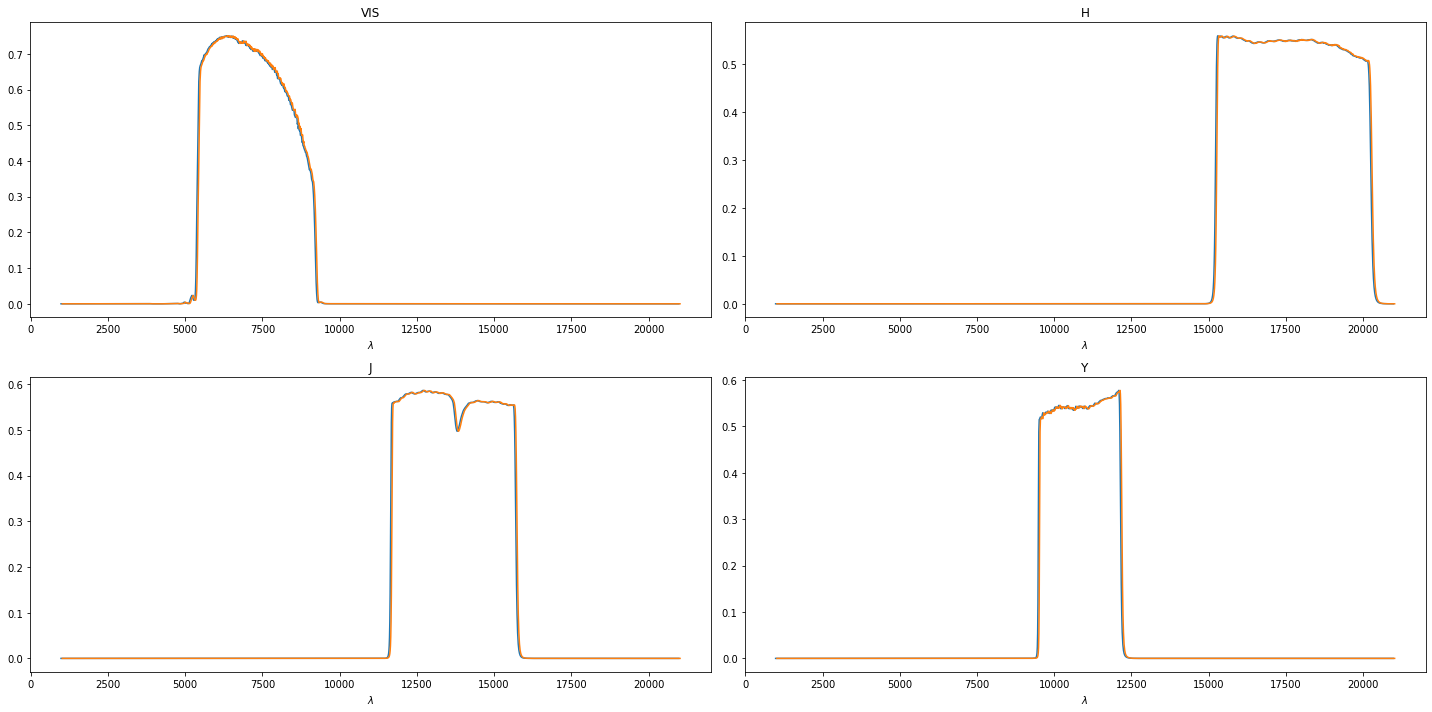

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes = axes.ravel()

for j, f in enumerate(['VIS', 'H', 'J', 'Y']):
    axes[j].set_title(f)  
    shifted_f = filter_provider.getShifts(f)
    for sf in [shifted_f[0], shifted_f[-1]]:
        trans = filter_provider.getFilterTransmission(sf)
        axes[j].plot(trans[:,0], trans[:,1], label=sf)
        axes[j].set_xlabel('$\lambda$')
plt.tight_layout()
plt.show()

In [11]:
pre_post_processor = FnuuJyPrePostProcessor()

In [12]:
phot_builder = ReferenceSamplePhotometryBuilder(filter_provider, pre_post_processor)
phot_builder.setFilters(filter_provider.getFilterNames())

In [13]:
# Speed up things bit
import types
def ref_sample_subset(size):
    use_ids = np.random.choice(ref_sample.getIds(), size)
    for i in use_ids:
        yield types.SimpleNamespace(sed=ref_sample.getSedData(i), pdz=ref_sample.getPdzData(i))

In [14]:
samp_size = ref_sample.size() // 200
pbar = tqdm(total=samp_size)
ref_subset = list(ref_sample_subset(samp_size))
photometry_dict = phot_builder.buildPhotometry(ref_subset, lambda i: pbar.update())

In [15]:
# Append median redshift, just for curiosity
photometry_dict['Z'] = [np.average(o.pdz[:,0], weights=o.pdz[:,1]) for o in ref_subset]

In [16]:
photometry = Table(photometry_dict)

In [17]:
print(np.max(photometry['Z']))
print(np.min(photometry['Z']))

4.75439
1.1270046e-32


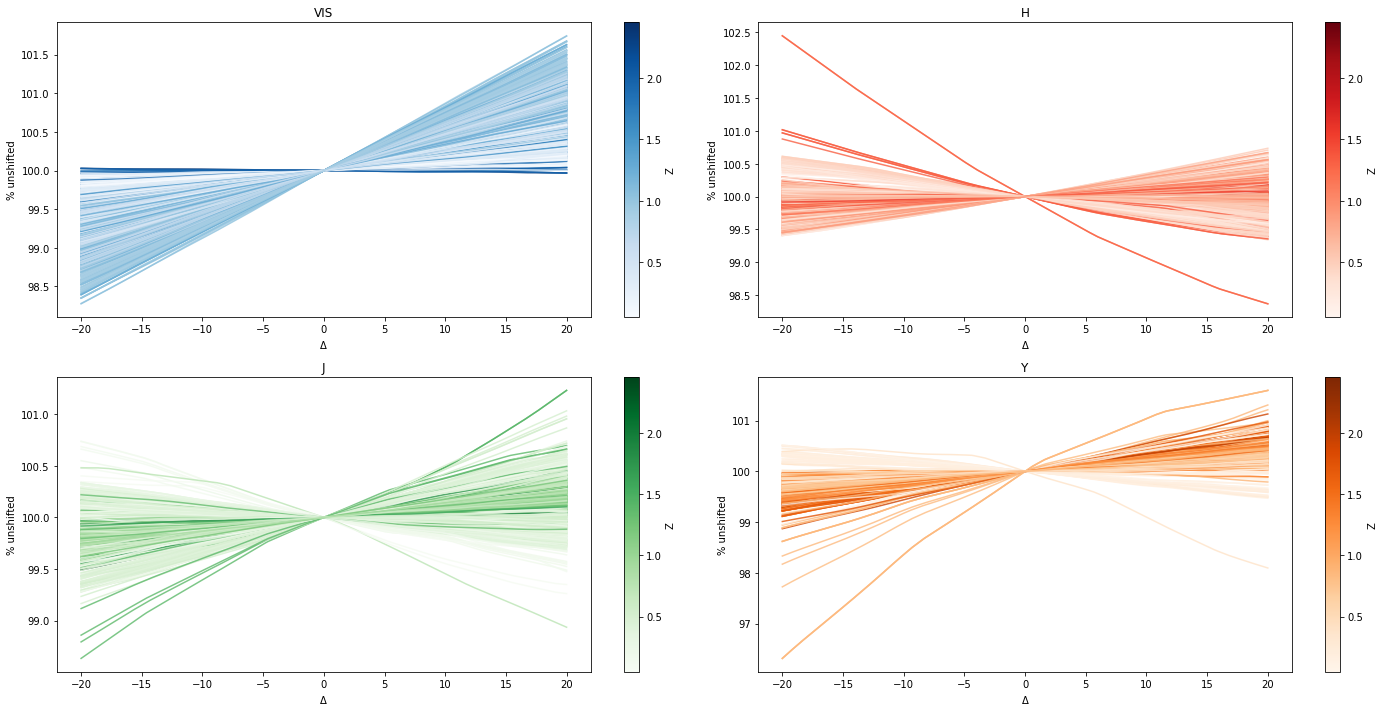

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes = axes.ravel()
choices = list(np.random.choice(np.arange(len(photometry)), 1000))
for j, f in enumerate(['VIS', 'H', 'J', 'Y']):
    axes[j].set_title(f)
    redshifts = photometry['Z'][choices]
    cmap = plt.get_cmap(['Blues', 'Reds', 'Greens', 'Oranges'][j])
    norm = colors.Normalize(vmin=redshifts.min(), vmax=redshifts.max())
    for i in choices:
        y = np.array([photometry[sf][i] for sf in filter_provider.getShifts(f)])
        y /= y[len(y)//2]
        axes[j].plot(filter_provider._shifts, y*100., alpha=0.8, c=cmap(norm(photometry['Z'][i])))
        axes[j].set_xlabel('$\Delta$')
        axes[j].set_ylabel('% unshifted')
    plt.colorbar(cm.ScalarMappable(norm, cmap), ax=axes[j]).set_label('Z')
plt.tight_layout()